<a href="https://colab.research.google.com/github/Chang365/ESAA-25-1-assignments/blob/main/ESAA_25_2_0912_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 핸즈온 7장 앙상블 학습과 랜덤 포레스트 p.257 - 272

## 7.5 부스팅

- 부스팅(가설 부스팅): 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법


### 7.5.1 에이다부스트

- 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것 -> 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰짐

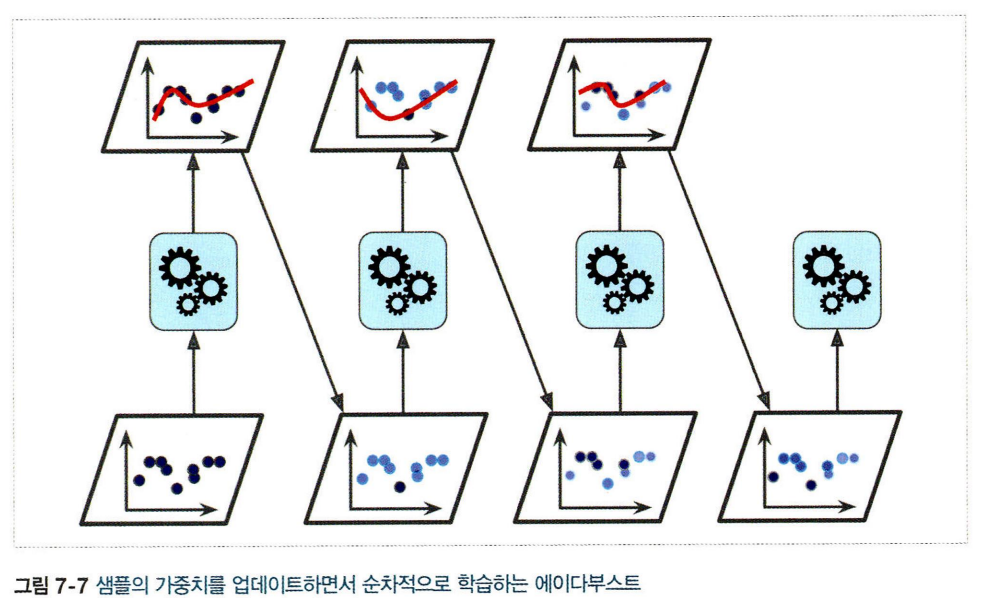

-> 첫번째 분류기를 훈련세트에서 훈련시키고 예측을 만듦 -> 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높음 -> 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만듦 -> 다시 가중치 업데이트

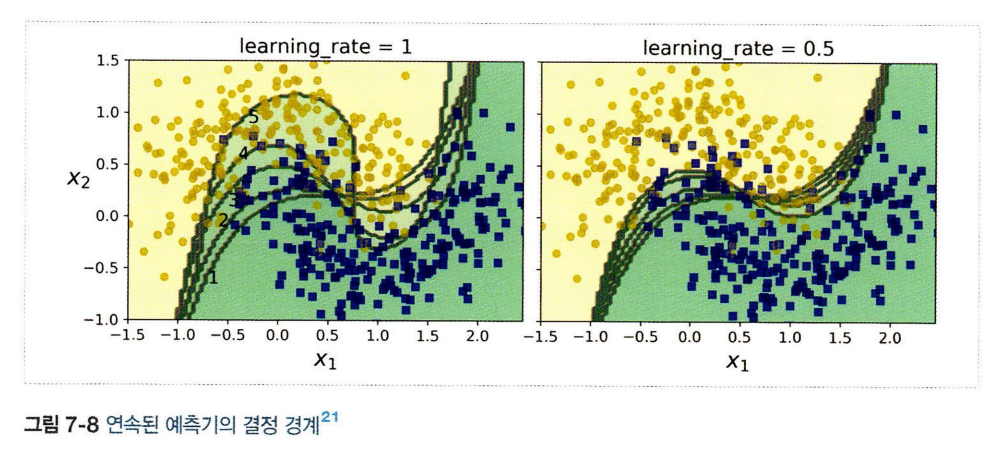

-> 첫번째 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아짐 -> 두번째 분류기는 이 샘플들을 더 정확히 예측

- 경사하강법은 비용함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면 에이다 부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가

- 병렬화 불가함

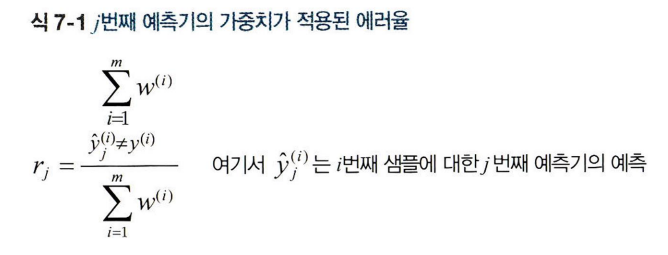



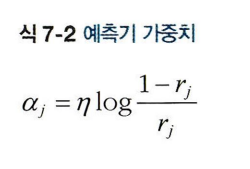

- 예측기가 정확할수록 가중치가 더 높아짐
- 무작위로 예측하는 정도라면 가중치가 0에 가까움


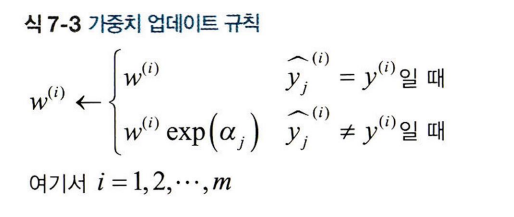

- 샘플의 가중치 업데이트
- 잘못 분류된 샘플의 가중치 증가

-> 모든 샘플의 가중치 정규화

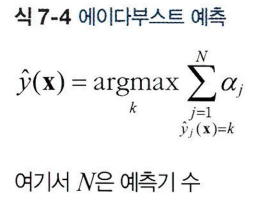

-> 가중치 합이 가장 큰 클래스가 예측결과가 됨

In [2]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [3]:
# AdaBoostClassifier 사용해 200개의 얕은 결정 트리 기반 훈련
# 결정 트리는 max_depth=1 (즉, 결정 노드 하나와 리프 노드 두 개로 이루어진 트리)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME", learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅

- 이전 예측기가 만든 잔여오차에 새로운 예측기를 학습시킴
- **그레이디언트 트리 부스팅, 그레이디언트 부스티드 회귀 트리**

In [4]:
# DecisionTreeRegressor를 훈련 세트에 학습
# 잡음이 섞인 2차 곡선 형태의 훈련 세트

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [5]:
# 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor 훈련

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [6]:
# 두 번째 예측기에서 생긴 잔여 오차에 세 번째 DecisionTreeRegressor 훈련

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [7]:
# 모든 트리의 예측을 더해서 새로운 샘플에 대한 예측 만들기

X_new = np.array([[0.8, 0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([-0.13329396])

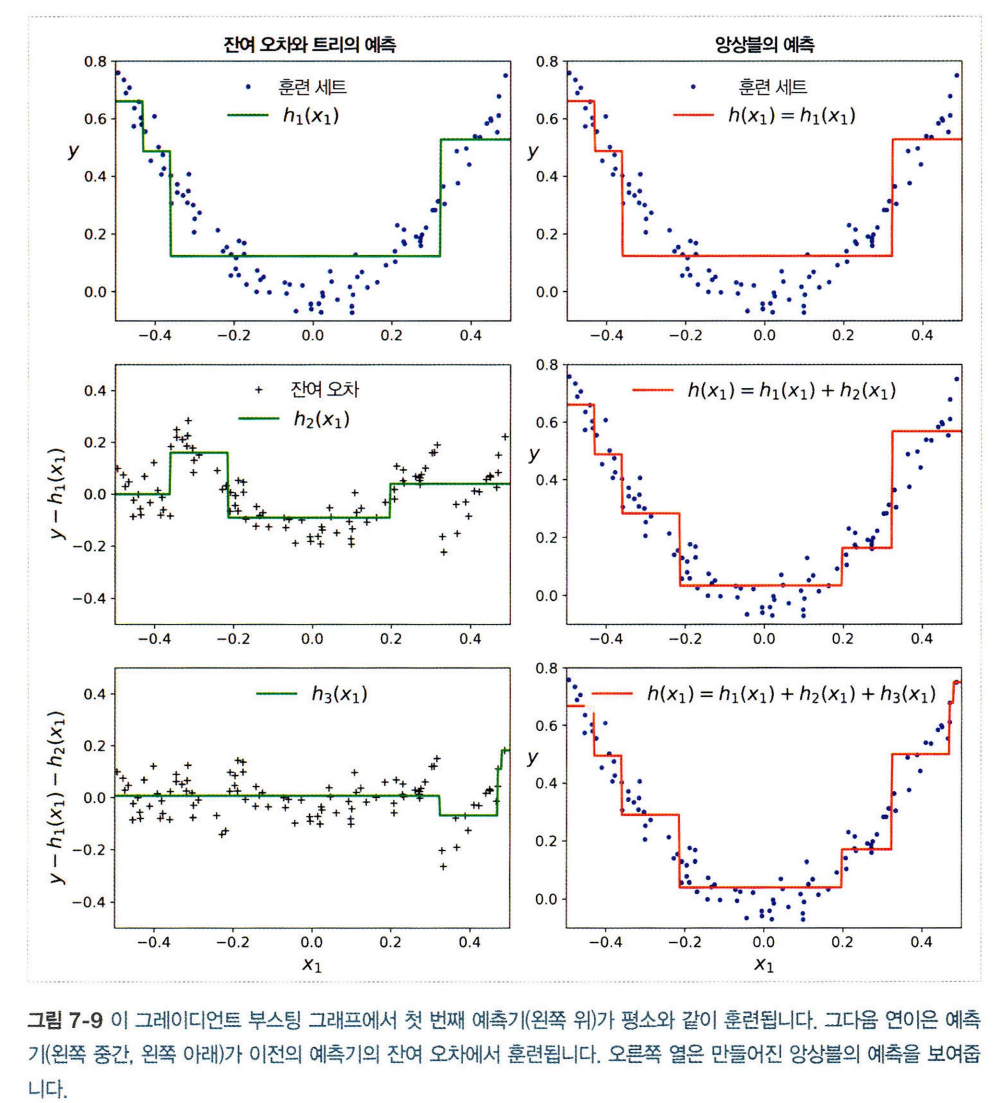

- 첫번째 행: 앙상블에 트리가 하나만 있어서 첫번째 트리의 예측과 같음

- 두번째 행: 새로운 트리가 첫번째 트리의 잔여 오차에 대해 학습, 앙상블 예측이 두 개의 트리 예측의 합과 같음

- 세번째 행: 두 번째 트리의 잔여 오차에 훈련됨





In [8]:
# GradientBoostRegressor 사용
# GBRT 앙상블 훈련

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

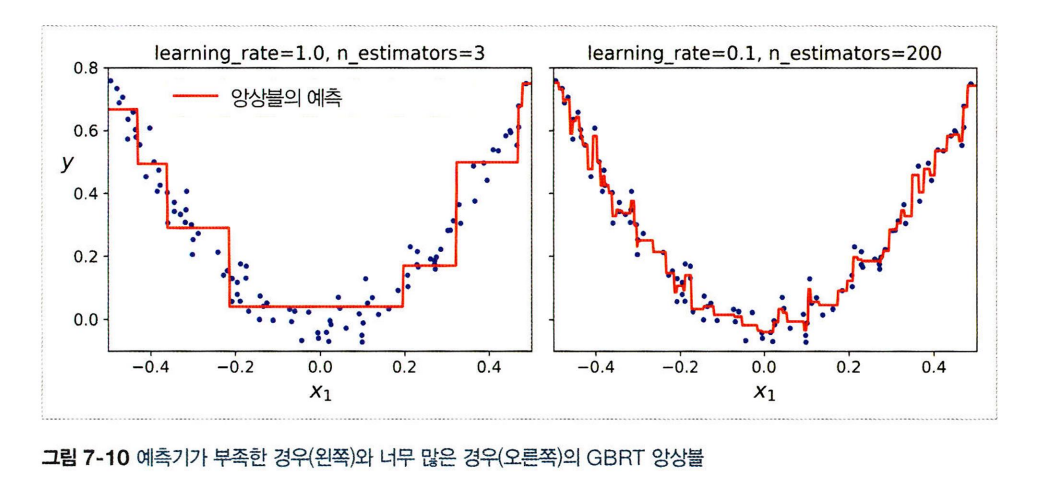

-> 최적의 트리 수를 찾기 위해서 **조기종료**

In [9]:
# 120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차 측정

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(63))

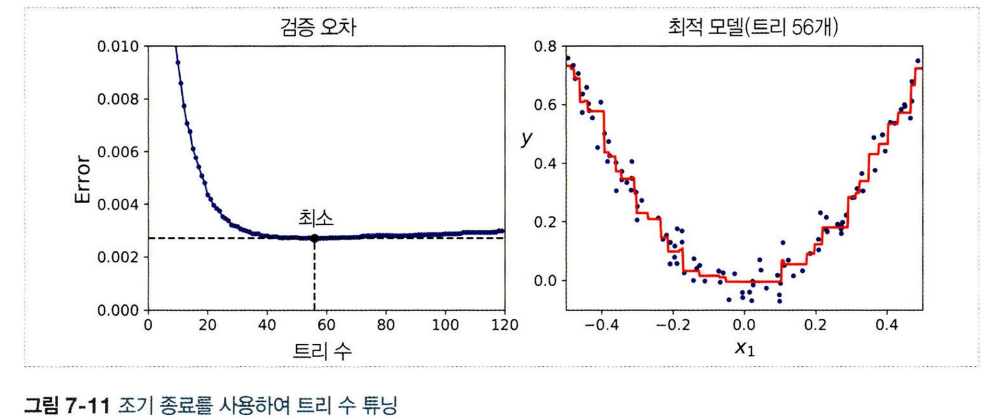

- 실제로 훈련을 중지하는 방법으로 조기 종료 구현 가능

In [10]:
#warm_start=True 겅정
# 연속 5번 반복동안 검증 오차 향상되지 않으면 훈련을 멈춤

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # 조기 종료

확률적 그레이디언트 부스트
- 편향이 높아지고, 분산이 낮아짐
- 훈련속도 빨라짐

In [11]:
# XGBoost(익스트림 그레이디언트 부스팅)

import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [12]:
# XGBoost의 자동 조기 종료

xgb_reg = xgboost.XGBRegressor(early_stopping_rounds = 2)
xgb_reg.fit(X_train, y_train,
            eval_set = [(X_test, y_test)])
y_pred = xgb_reg.predict(X_test)

mean_squared_error(y_test, y_pred)

[0]	validation_0-rmse:0.38293
[1]	validation_0-rmse:0.29085
[2]	validation_0-rmse:0.22311
[3]	validation_0-rmse:0.17641
[4]	validation_0-rmse:0.14231
[5]	validation_0-rmse:0.11797
[6]	validation_0-rmse:0.09939
[7]	validation_0-rmse:0.08696
[8]	validation_0-rmse:0.07878
[9]	validation_0-rmse:0.07039
[10]	validation_0-rmse:0.06623
[11]	validation_0-rmse:0.06080
[12]	validation_0-rmse:0.05676
[13]	validation_0-rmse:0.05508
[14]	validation_0-rmse:0.05391
[15]	validation_0-rmse:0.05311
[16]	validation_0-rmse:0.05236
[17]	validation_0-rmse:0.05174
[18]	validation_0-rmse:0.05134
[19]	validation_0-rmse:0.05111
[20]	validation_0-rmse:0.05090
[21]	validation_0-rmse:0.05074
[22]	validation_0-rmse:0.05095
[23]	validation_0-rmse:0.05114


0.00257427548058331

## 7.6 스태킹

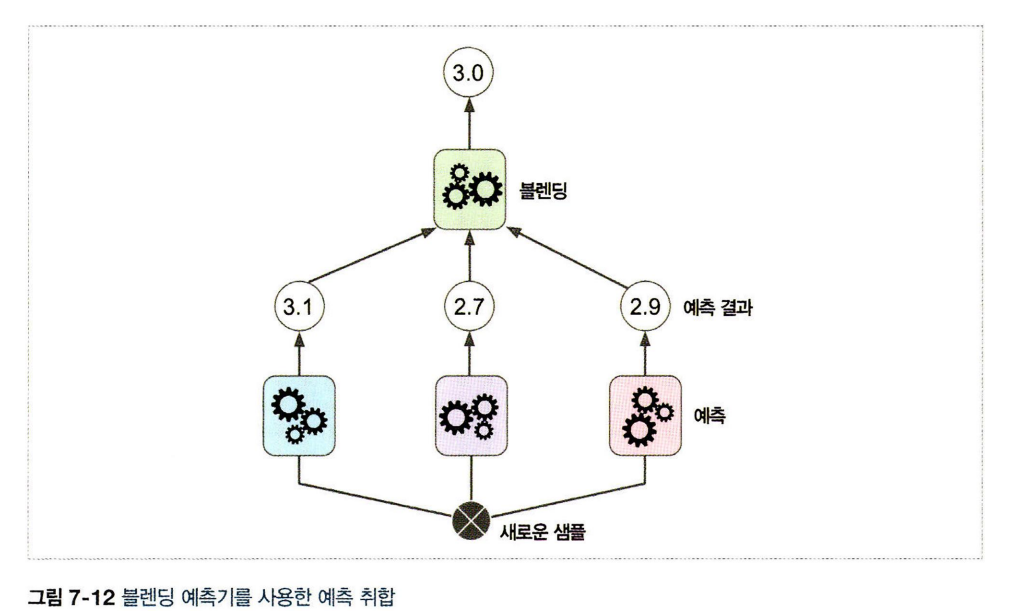